In [9]:
from API import XTB
from config import base_url, userId, password

# Create an instance of the XTB API
xtb = XTB(base_url, userId, password)

In [12]:
symbols = xtb.get_AllSymbols()

In [29]:
symbols['returnData'][10]

{'symbol': 'WCC.US_4',
 'currency': 'USD',
 'categoryName': 'STC',
 'currencyProfit': 'USD',
 'quoteId': 6,
 'quoteIdCross': 4,
 'marginMode': 103,
 'profitMode': 6,
 'pipsPrecision': 2,
 'contractSize': 1,
 'exemode': 1,
 'time': 1724777579446,
 'expiration': None,
 'stopsLevel': 0,
 'precision': 2,
 'swapType': 2,
 'stepRuleId': 671,
 'type': 13,
 'instantMaxVolume': 2147483647,
 'groupName': 'US',
 'description': 'Wesco International Inc CFD',
 'longOnly': False,
 'trailingEnabled': False,
 'marginHedgedStrong': False,
 'swapEnable': True,
 'percentage': 100.0,
 'bid': 162.45,
 'ask': 163.35,
 'high': 163.82,
 'low': 161.34,
 'lotMin': 1.0,
 'lotMax': 1000000.0,
 'lotStep': 1.0,
 'tickSize': 0.01,
 'tickValue': 0.01,
 'swapLong': -0.02728,
 'swapShort': 0.0,
 'leverage': 30.0,
 'spreadRaw': 0.9,
 'spreadTable': 90.0,
 'starting': None,
 'swap_rollover3days': 0,
 'marginMaintenance': 0,
 'marginHedged': 0,
 'initialMargin': 0,
 'shortSelling': True,
 'timeString': 'Tue Aug 27 18:52:5

In [30]:
forex_currencies = [symbol for symbol in symbols['returnData'] if symbol['categoryName'] == 'FX']
#add a lotMinMargin field to each symbol
for symbol in forex_currencies:
    symbol['lotMinMargin'] = xtb.get_Margin(symbol["symbol"], symbol["lotMin"])
forex_currencies[0]

{'symbol': 'EURAUD',
 'currency': 'EUR',
 'categoryName': 'FX',
 'currencyProfit': 'AUD',
 'quoteId': 5,
 'quoteIdCross': 4,
 'marginMode': 101,
 'profitMode': 5,
 'pipsPrecision': 4,
 'contractSize': 100000,
 'exemode': 1,
 'time': 1724777579146,
 'expiration': None,
 'stopsLevel': 0,
 'precision': 5,
 'swapType': 3,
 'stepRuleId': 5,
 'type': 984,
 'instantMaxVolume': 2147483647,
 'groupName': 'Minor',
 'description': 'Euro to Australian Dollar',
 'longOnly': False,
 'trailingEnabled': True,
 'marginHedgedStrong': False,
 'swapEnable': True,
 'percentage': 100.0,
 'bid': 1.64684,
 'ask': 1.64703,
 'high': 1.65045,
 'low': 1.64463,
 'lotMin': 0.01,
 'lotMax': 100.0,
 'lotStep': 0.01,
 'tickSize': 1e-05,
 'tickValue': 1.0,
 'swapLong': -0.005088,
 'swapShort': -0.001795,
 'leverage': 5.0,
 'spreadRaw': 0.00019,
 'spreadTable': 1.9,
 'starting': None,
 'swap_rollover3days': 0,
 'marginMaintenance': 0,
 'marginHedged': 0,
 'initialMargin': 0,
 'shortSelling': True,
 'timeString': 'Tue Au

In [41]:
def calculate_trade_volume(balance, symbolInfos, risk_percentage=10):
        """
        Calculate the trade volume based on the balance, leverage, and risk management.
        The balance is in EUR, and we use the lotMinMargin field from symbolInfos.
        The function also ensures that the balance is sufficient for the calculated volume.
        """
        # Calculate the amount of money we are willing to risk
        risk_amount = balance * (risk_percentage / 100)

        # Use the lotMinMargin directly from the symbolInfos
        lot_min_margin = symbolInfos['lotMinMargin']

        # Calculate the initial volume based on the risk amount and minimum lot margin
        volume = (risk_amount / lot_min_margin) * symbolInfos['lotMin']

        # Ensure volume respects broker's min, max, and step constraints
        volume = max(min(volume, symbolInfos['lotMax']), symbolInfos['lotMin'])
        volume = round(volume / symbolInfos['lotStep']) * symbolInfos['lotStep']

        # Check if the calculated volume requires more margin than available in the balance
        required_margin = volume * lot_min_margin / symbolInfos['lotMin']
        if required_margin > balance:
            # If the required margin exceeds the balance, adjust the volume downwards
            volume = (balance / lot_min_margin) * symbolInfos['lotMin']
            volume = max(min(volume, symbolInfos['lotMax']), symbolInfos['lotMin'])
            volume = round(volume / symbolInfos['lotStep']) * symbolInfos['lotStep']

        return volume


print(calculate_trade_volume(1000, forex_currencies[0]))

'''# print for all forex currencies
for forex_currency in forex_currencies:
    volume = calculate_trade_volume(1000, forex_currency, forex_currencies)
    print(f"Volume for {forex_currency['description']} is {volume:.2f}")'''


0.02


'# print for all forex currencies\nfor forex_currency in forex_currencies:\n    volume = calculate_trade_volume(1000, forex_currency, forex_currencies)\n    print(f"Volume for {forex_currency[\'description\']} is {volume:.2f}")'

In [10]:
forex_currencies[13]

'USDCLP'

In [6]:
from tqdm import tqdm

#forex_currencies = ["EURAUD", "EURCAD", "EURCHF", "EURGBP", "EURJPY", "EURNZD", "EURUSD", "GBPAUD", "GBPCAD", "GBPCHF", "GBPJPY", "GBPNZD", "GBPUSD", "USDCAD", "USDJPY", "AUDCAD", "AUDCHF", "CADCHF", "CADJPY", "CHFJPY", "NZDCAD", "NZDCHF", "NZDJPY", "NZDUSD"]
period = 'D1'
dataSample = {}
currency_errors = []
for currency in tqdm(forex_currencies, desc=f"Downloading {len(forex_currencies)} forex currencies"):
    data = {}
    data["symbolInfos"] = xtb.get_Symbol(currency)
    #try catch to avoid errors when the API returns an error and add the currency to the currency_errors list
    #data["candles"] = xtb.get_Candles('H1', currency, qty_candles=10000)[1:]
    try:
        data["candles"] = xtb.get_Candles(period, currency, qty_candles=10000)[1:]
    except:
        currency_errors.append(currency)
    dataSample[currency] = data

#save data to a json file in samples folder
import json
with open(f"samples/forex_{period}.json", 'w') as f:
    json.dump(dataSample, f)

#print the currencies that had an error
print(f"Errors with the following currencies: {currency_errors}")


Errors with the following currencies: ['EURAUD', 'GBPMXN', 'USDINR', 'GBPJPY', 'USDSEK', 'ZARJPY', 'CHFPLN', 'AUDJPY', 'AUDCHF', 'NZDUSD', 'EURRON', 'EURSEK', 'USDCLP', 'CHFSEK', 'USDSGD', 'EURNOK', 'GBPPLN', 'GBPUSD', 'EURCZK', 'EURCNH', 'USDNOK', 'EURCHF', 'GBPZAR', 'USDTHB', 'USDCZK', 'USDCNH', 'EURSGD', 'NZDJPY', 'EURCAD', 'EURGBP', 'CHFHUF', 'AUDCAD', 'USDBRL', 'USDCAD', 'CHFNOK', 'NOKSEK', 'GBPSEK', 'EURJPY', 'EURMXN', 'USDJPY', 'USDILS', 'USDMXN', 'EURZAR', 'GBPNZD', 'USDZAR', 'NZDCHF', 'NZDSGD', 'CHFJPY', 'GBPAUD', 'GBPCHF', 'CADMXN', 'CADJPY', 'USDTRY', 'USDHUF', 'EURHUF', 'GBPSGD', 'EURNZD', 'USDRON', 'EURUSD', 'GBPNOK', 'CADCHF', 'EURTRY']


In [ ]:
data

[{'datetime': 'Aug 20, 2024, 7:00:00 PM',
  'open': 164988.0,
  'close': 164955.0,
  'high': 165043.0,
  'low': 164930.0,
  'type': 'Bearish'},
 {'datetime': 'Aug 20, 2024, 7:15:00 PM',
  'open': 164955.0,
  'close': 164994.0,
  'high': 165006.0,
  'low': 164928.0,
  'type': 'Bullish'},
 {'datetime': 'Aug 20, 2024, 7:30:00 PM',
  'open': 164994.0,
  'close': 164999.0,
  'high': 165028.0,
  'low': 164971.0,
  'type': 'Bullish'},
 {'datetime': 'Aug 20, 2024, 7:45:00 PM',
  'open': 165000.0,
  'close': 164971.0,
  'high': 165014.0,
  'low': 164960.0,
  'type': 'Bearish'},
 {'datetime': 'Aug 20, 2024, 8:00:00 PM',
  'open': 164971.0,
  'close': 164854.0,
  'high': 164971.0,
  'low': 164835.0,
  'type': 'Bearish'},
 {'datetime': 'Aug 20, 2024, 8:15:00 PM',
  'open': 164853.0,
  'close': 164862.0,
  'high': 164865.0,
  'low': 164819.0,
  'type': 'Bullish'},
 {'datetime': 'Aug 20, 2024, 8:30:00 PM',
  'open': 164862.0,
  'close': 164842.0,
  'high': 164881.0,
  'low': 164825.0,
  'type': 'Bea

In [3]:
import json
#import data from json file candle_data.json
with open('candle_data.json') as f:
    data = json.load(f)

In [4]:
import pandas as pd

class Indicator:
    def isEngulfing(self, data):
        # Previous candle (third to last)
        prev_open = data[-3]["open"]
        prev_close = data[-3]["close"]
        
        # Current candle (second to last)
        curr_open = data[-2]["open"]
        curr_close = data[-2]["close"]
        
        # Check for bullish engulfing pattern
        if prev_close < prev_open and curr_close > curr_open and curr_open < prev_close and curr_close > prev_open:
            return True
        
        # Check for bearish engulfing pattern
        if prev_close > prev_open and curr_close < curr_open and curr_open > prev_close and curr_close < prev_open:
            return True
        
        return False

    def calculate_atr(self, df, period):
        df['H-L'] = df['high'] - df['low']
        df['H-PC'] = abs(df['high'] - df['close'].shift(1))
        df['L-PC'] = abs(df['low'] - df['close'].shift(1))
        
        df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
        df['ATR'] = df['TR'].rolling(window=period).mean()
        
        return df['ATR']

    def calculate_supertrend(self, data, period=7, multiplier=3):
        df = pd.DataFrame(data)
        df['ATR'] = self.calculate_atr(df, period)
        
        df['Upper Band'] = ((df['high'] + df['low']) / 2) + (multiplier * df['ATR'])
        df['Lower Band'] = ((df['high'] + df['low']) / 2) - (multiplier * df['ATR'])
        
        df['Supertrend'] = 0.0
        df.loc[0, 'Supertrend'] = df.loc[0, 'Upper Band'] if df.loc[0, 'close'] > df.loc[0, 'Upper Band'] else df.loc[0, 'Lower Band']
        
        for i in range(1, len(df)):
            if df.loc[i-1, 'close'] > df.loc[i-1, 'Supertrend']:
                df.loc[i, 'Supertrend'] = df.loc[i, 'Lower Band'] if df.loc[i, 'close'] > df.loc[i, 'Lower Band'] else df.loc[i, 'Upper Band']
            else:
                df.loc[i, 'Supertrend'] = df.loc[i, 'Upper Band'] if df.loc[i, 'close'] < df.loc[i, 'Upper Band'] else df.loc[i, 'Lower Band']
        
        return df['Supertrend']

    def bullish_engulfing(self, data):
        if data[-2]["type"] == "Bullish" and data[-3]["type"] == "Bearish" and self.isEngulfing(data):
            return True
        else:
            return False
    
    def bearish_engulfing(self, data):
        if data[-2]["type"] == "Bearish" and data[-3]["type"] == "Bullish" and self.isEngulfing(data):
            return True
        else:
            return False

class SignalDetector:
    def __init__(self):
        self.signal = "None"
        self.indicator = Indicator()

    def check_enterTrade_signal(self, data):
        supertrend1 = self.indicator.calculate_supertrend(data, period=10, multiplier=1)
        supertrend2 = self.indicator.calculate_supertrend(data, period=12, multiplier=3)
        supertrend3 = self.indicator.calculate_supertrend(data, period=11, multiplier=2)

        supertrend1_last = supertrend1.iloc[-1]
        supertrend1_prev = supertrend1.iloc[-2]
        supertrend2_last = supertrend2.iloc[-1]
        supertrend2_prev = supertrend2.iloc[-2]
        supertrend3_last = supertrend3.iloc[-1]
        supertrend3_prev = supertrend3.iloc[-2]

        if self.indicator.bullish_engulfing(data):
            if (
                supertrend1_last > supertrend1_prev and
                supertrend2_last > supertrend2_prev and
                supertrend3_last > supertrend3_prev):
                self.signal = "buy"
                return self.signal

        elif self.indicator.bearish_engulfing(data):
            if (
                supertrend1_last < supertrend1_prev and
                supertrend2_last < supertrend2_prev and
                supertrend3_last < supertrend3_prev):
                self.signal = "sell"
                return self.signal

        self.signal = "None"
        return self.signal
    
    def check_exitTrade_signal(self, data):
        supertrend1 = self.indicator.calculate_supertrend(data, period=10, multiplier=1)
        supertrend2 = self.indicator.calculate_supertrend(data, period=12, multiplier=3)
        supertrend3 = self.indicator.calculate_supertrend(data, period=11, multiplier=2)

        supertrend1_last = supertrend1.iloc[-1]
        supertrend1_prev = supertrend1.iloc[-2]
        supertrend2_last = supertrend2.iloc[-1]
        supertrend2_prev = supertrend2.iloc[-2]
        supertrend3_last = supertrend3.iloc[-1]
        supertrend3_prev = supertrend3.iloc[-2]

        if self.signal == "buy":
            if (
                supertrend1_last < supertrend1_prev or
                supertrend2_last < supertrend2_prev or
                supertrend3_last < supertrend3_prev):
                self.signal = "exit"
                return self.signal
        
        elif self.signal == "sell":
            if (
                supertrend1_last > supertrend1_prev or
                supertrend2_last > supertrend2_prev or
                supertrend3_last > supertrend3_prev):
                self.signal = "exit"
                return self.signal
        
        self.signal = "None"
        return self.signal

indicator = Indicator()

supertrend1 = indicator.calculate_supertrend(data, 10, 1)
supertrend2 = indicator.calculate_supertrend(data, 12, 3)
supertrend3 = indicator.calculate_supertrend(data, 11, 2)

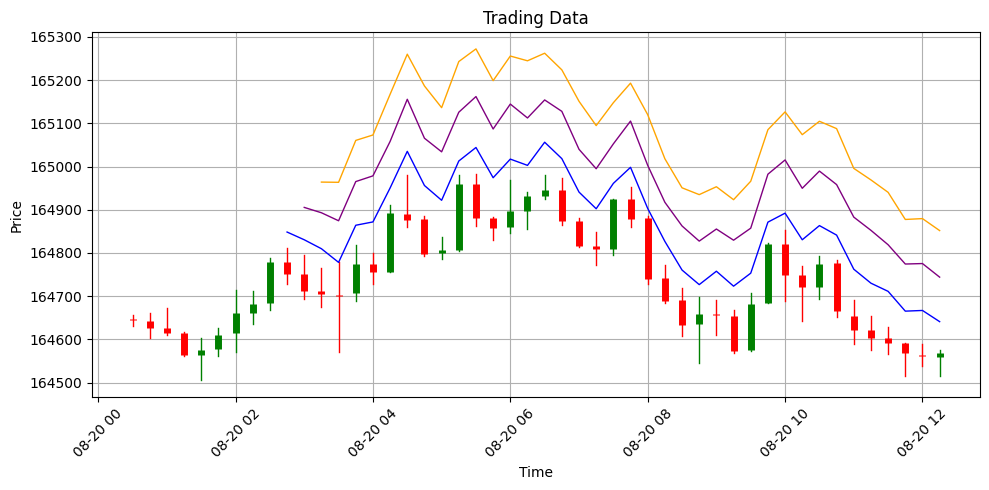

In [5]:
import matplotlib.pyplot as plt
from datetime import datetime

# Parsing the datetime and extracting relevant data
times = [datetime.strptime(d['datetime'], '%b %d, %Y, %I:%M:%S %p') for d in data]
opens = [d['open'] for d in data]
closes = [d['close'] for d in data]
highs = [d['high'] for d in data]
lows = [d['low'] for d in data]
types = [d['type'] for d in data]

# Plotting the data
plt.figure(figsize=(10, 5))

# Plotting high-low range as thin lines centered with open-close range
for i in range(len(times)):
    color = 'green' if types[i] == 'Bullish' else 'red'
    plt.plot([times[i], times[i]], [lows[i], highs[i]], color=color, linewidth=1)
    plt.plot([times[i], times[i]], [opens[i], closes[i]], color=color, linewidth=5, solid_capstyle='butt')

# Plotting the supertrend
plt.plot(times, supertrend1, label='Supertrend', color='blue', linewidth=1)
plt.plot(times, supertrend2, label='Supertrend', color='orange', linewidth=1)
plt.plot(times, supertrend3, label='Supertrend', color='purple', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Trading Data')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
signal_detector = SignalDetector()

for i in range(13, len(data)):
    signal = signal_detector.check_enterTrade_signal(data[i-13:i])
    if signal != "None":
        print(f"candle {i}: {signal}")
    signal = signal_detector.check_exitTrade_signal(data[i-13:i])
    if signal != "None":
        print(f"candle {i}: {signal}")

candle 43: sell


In [16]:
#write candle data to a json
import json

with open('candle_data.json', 'w') as f:
    json.dump(data[1:], f)